In [423]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

from ipywidgets import interact, FloatSlider, IntSlider
from IPython.display import display
from ipywidgets import HBox, VBox, Layout, widgets

from sympy import solve, diff, symbols, Matrix, Symbol
import sympy.core.numbers as spn

from typing import List, Union, Tuple
import time

# interactive plots
%matplotlib widget

<h1> 7 Chaos </h1>
<h2> 7.1 Continuous time </h2>
<h3> 7.1.1 Simulate chaos </h3>

In [333]:
"""General functions"""


def euler_int(start, f, dt, steps, *args, **kwargs):
    """
    function implementing the euler method for integrating a function with N variables
    """
    eul = np.zeros((steps, len(start)))
    eul[0] = start
    
    for i in range(steps-1):
        eul[i+1] = eul[i] + dt * f(*eul[i], *args, **kwargs)
    
    return eul.T # return the transpose so we can use X, Y, Z = euler_int( ... )


def get_color_range(N, c_map_name):
    """
    create a range of N discrete colors from a matplotlib colormap
    """
    cmap = cm.get_cmap(c_map_name)
    return [cmap(i) for i in np.linspace(0, 1, N)]


class Markup:
    RED = '\033[91m'
    GREEN = '\033[92m'
    B = '\033[1m'
    U = '\033[4m'
    END = '\033[0m'

    @staticmethod
    def b_red(s: str) -> str:
        return Markup.B + Markup.RED + s + Markup.END

    @staticmethod
    def b_green(s: str) -> str:
        return Markup.B + Markup.GREEN + s + Markup.END

    @staticmethod
    def bold(s: str) -> str:
        return Markup.B + s + Markup.END

In [334]:
"""Food chain model functions"""


def food_chain_model(X, Y, Z, a1, a2, b1, b2, d1, d2):
    def X_prime(X, Y, a1, b1):
        return X*(1-X) - a1*X*Y / (1 + b1*X)
    
    def Y_prime(X, Y, Z, a1, a2, b1, b2, d1):
        return a1*X*Y / (1 + b1*X) - d1*Y - a2*Y*Z / (1 + b2*Y)
    
    def Z_prime(Y, Z, a2, b2, d2):
        return a2*Y*Z / (1 + b2*Y) - d2*Z
    
    return np.array([X_prime(X, Y, a1, b1),
                     Y_prime(X, Y, Z, a1, a2, b1, b2, d1),
                     Z_prime(Y, Z, a2, b2, d2)])


def plot_food(ax_traject, ax_time, start, constants, dt=0.01, nsteps=100000):
    cmap = get_color_range(len(start), 'autumn')
    alpha = 1/len(start)
    for n, i in enumerate(start):
        X, Y, Z = euler_int(i, food_chain_model, dt, nsteps, **constants)
        
        ax_traject.plot(X, Y, Z, color=cmap[n], label='(X, Y, Z) = ({:.2f}, {:.2f}, {:.2f})'.format(*i), alpha=alpha)
        ax_traject.set_xlabel('X'), ax_traject.set_ylabel('Y'), ax_traject.set_zlabel('Z')
        
        if ax_time:
            time = np.array(range(nsteps))
            ax_time.plot(time, X, c='red', alpha=alpha)
            ax_time.plot(time, Y, c='blue', alpha=alpha)
            ax_time.plot(time, Z, c='green', alpha=alpha)

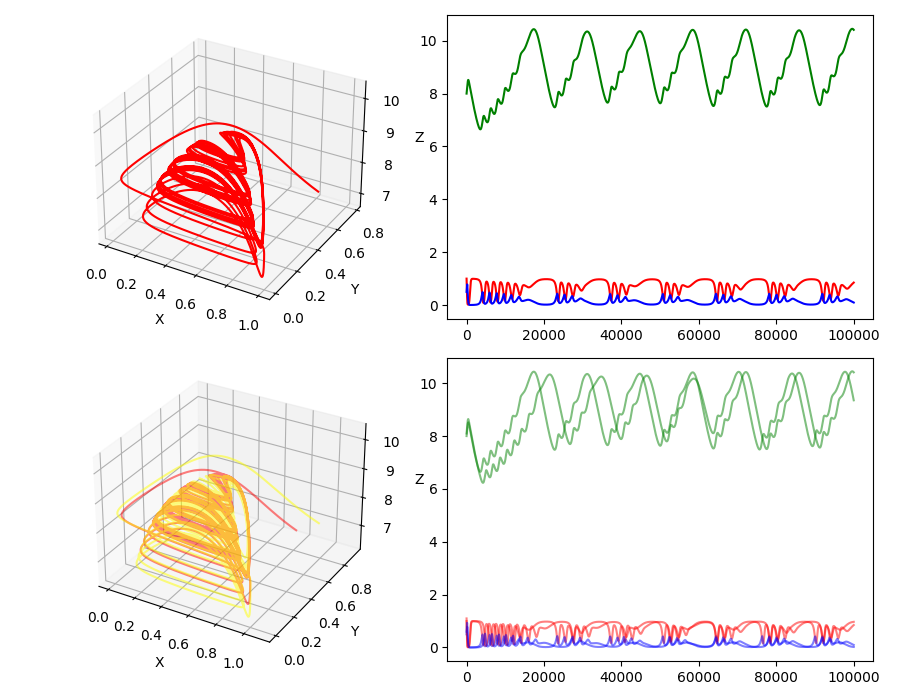

In [335]:
start = [(1.0, 0.5, 8.0), (1.1, 0.6, 8.1)]
constants = {'a1': 5, 'b1': 3, 'a2': 0.1, 'b2': 2, 'd1': 0.4, 'd2': 0.01}
f1 = plt.figure(figsize=(9, 7))
ax1 = f1.add_subplot(221, projection='3d')
ax2 = f1.add_subplot(222)
ax3 = f1.add_subplot(223, projection='3d')
ax4 = f1.add_subplot(224)
plot_food(ax1, ax2, [start[0]], constants)
plot_food(ax3, ax4, start, constants)
f1.tight_layout()
plt.show()

In [336]:
"""Calculating distance"""


distance = np.sqrt(np.sum(np.fromiter(((start[0][i] - start[1][i])**2 for i in range(3)), dtype=float)))
print('distance between ({:.2f}, {:.2f}, {:.2f}) and ({:.2f}, {:.2f}, {:.2f}) is {:.5f}'.format(*start[0], *start[1], distance))

distance between (1.00, 0.50, 8.00) and (1.10, 0.60, 8.10) is 0.17321


<h3> 7.1.2 Transition to chaos </h3>

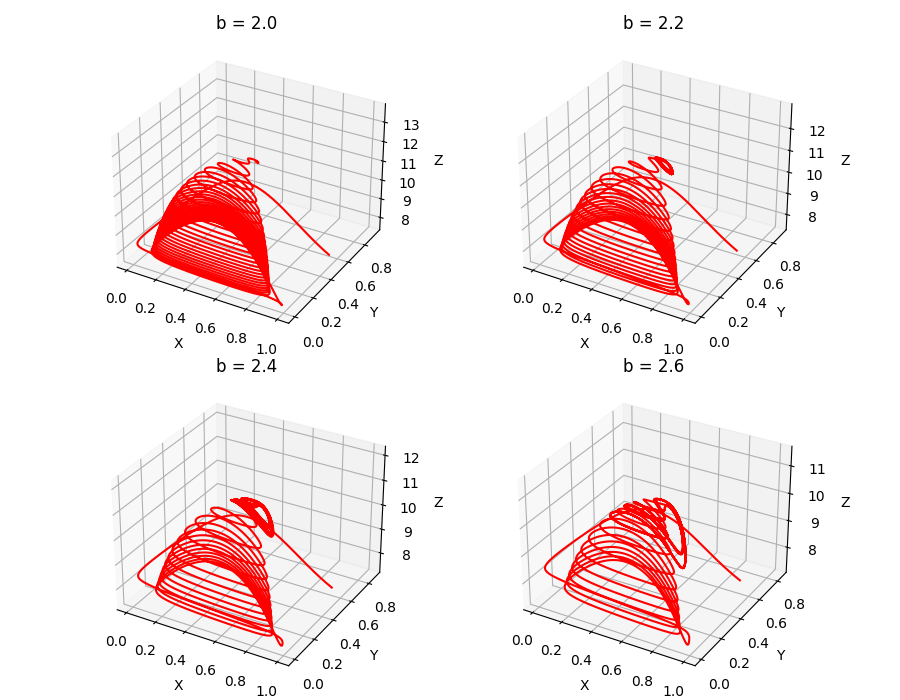

In [338]:
"""Varying b1"""


f2 = plt.figure(figsize=(9, 7))
for n, b in enumerate(range(20, 28, 2)):
    ax = f2.add_subplot(221 + n, projection='3d')
    constants['b1'] = b / 10
    plot_food(ax, None, [start[0]], constants)
    ax.set_title(f'b = {b / 10}')
f2.tight_layout()
plt.show()

<h2> 7.2 Continuous time </h2>

In [280]:
"""Constants"""
X_n = np.linspace(0, 1, 100)

In [339]:
"""Functions"""


def eq(x, r):
    return np.array([r*x*(1-x)])

In [340]:
def add_max_text(ax, X_n1):
    at = AnchoredText(f'max = {np.max(X_n1):.2f}', frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    return ax.add_artist(at)


def plot_r_line(ax, it, title, add_text=False):
    clist = get_color_range(len(it), 'inferno') if len(it) > 1 else ['red']
    for n, r_ in enumerate(it):
        line, = ax.plot(X_n, eq(X_n, r_)[0], c=clist[n], label=f'$r={r_:.1f}$')
        
    ax.set_xlabel('$X_n$')
    ax.set_ylabel('$X_{n+1}$')
    ax.set_title(title)
    return line, add_max_text(ax, X_n1) if add_text else line

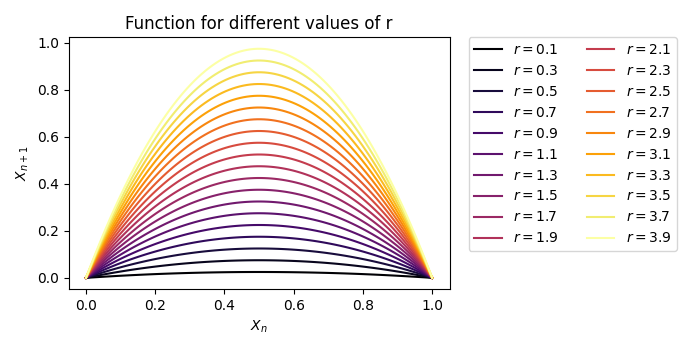

In [341]:
"""Plotting question 1"""
f3 = plt.figure(figsize=(7, 3.5))
ax3 = f3.add_subplot()
plot_r_line(ax3, np.array(range(1, 40, 2)) / 10, 'Function for different values of r')

ax3.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., ncol=len(it)//10)
f3.tight_layout()
plt.show()

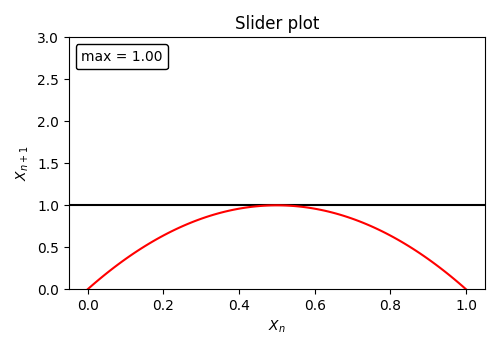

In [342]:
"""Plotting question 1 with widgets"""
f4 = plt.figure(figsize=(5, 3.5))
ax4 = f4.add_subplot()
ax4.axhline(1, -1, 2, c='black')
ax4.set_ylim(0, 3)

global text
line, text = plot_r_line(ax4, [4], 'Slider plot', add_text=True)
f4.tight_layout()


def update_plot(r_new):
    X_n1 = eq(X_n, r_new)[0]
    line.set_ydata(X_n1)
    
    global text
    text.remove()
    text = add_max_text(ax4, X_n1)


def on_slider_change(source):
    value = source['new']
    update_plot(value)


# Create slider
slider = widgets.FloatSlider(description=r"$r$", min=0, max=10, step=1, value=r, continuous_update=True)
slider.observe(on_slider_change, names='value')
HBox([slider ])

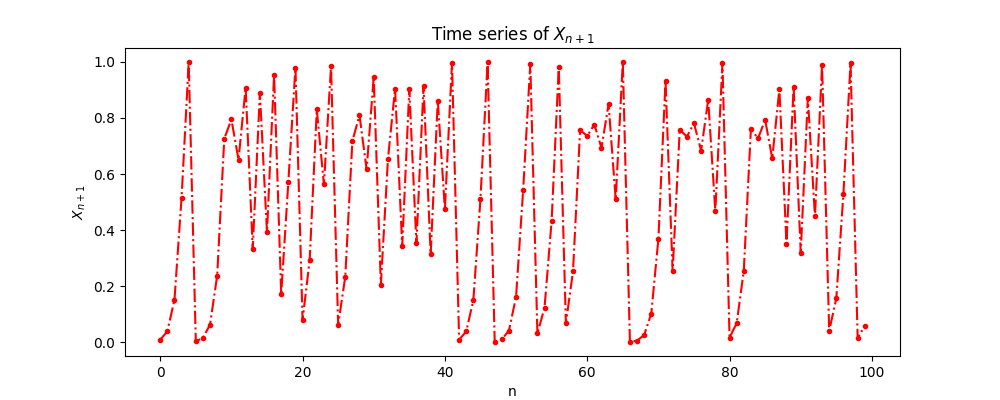

After 100 steps we find a value of:
X_n+1 = 0.8200138733909665


In [357]:
"""Plotting question 2"""

def time_series(start, f, steps, *args, **kwargs):
    time = np.zeros((steps, len(start)))
    time[0] = start
    for i in range(steps-1):
        time[i+1] = f(*time[i], *args, **kwargs)
    return time.T # return the transposed array so we can use X, Y, Z = euler_int( ... )


def plot_time_series(ax, start, l, r, c='red', style='-.', marker='.'):
    x, = time_series(start, eq, l, r)
    t = np.array(range(l))
    
    time, = ax.plot(t, x, label=r'$x_0$={}'.format(start[0]), linestyle=style, marker=marker, c=c)
    ax.set_ylabel(r'$X_{n+1}$')
    ax.set_xlabel('n')
    ax.set_title('Time series of $X_{n+1}$')
    return time, x


f5 = plt.figure(figsize=(10, 4.))
ax5 = f5.add_subplot()
plot_time_series(ax5, [0.01], 100, 4)
plt.show()

print(f'After {l} steps we find a value of:\n{Markup.bold("X_n+1 = " + str(x[-1]))}')

interactive(children=(FloatSlider(value=0.1, description='$X_0$', max=1.0, min=0.1), FloatSlider(value=4.0, de…

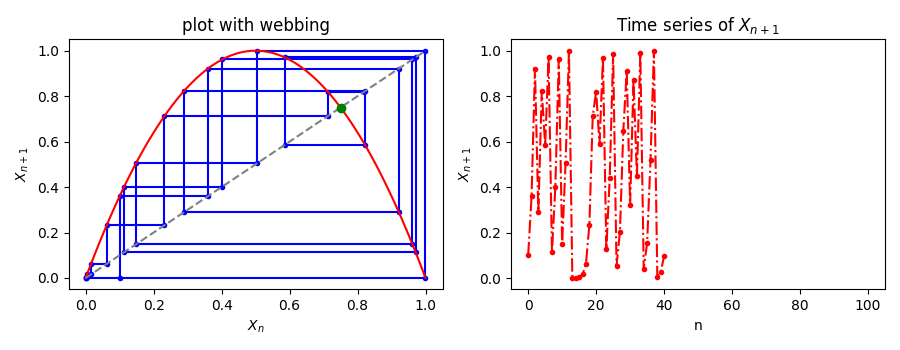

In [422]:
r_init = 4
l_init = 41
x0_init = 0.1


def cobwebbing(X_0, steps, r=4):
    x, y = np.zeros((2, steps))
    x[0], y[0] = X_0, 0
    for i in range(0, steps-1, 2):
        x[i+1], y[i+1] = x[i], eq(x[i], r)
        x[i+2], y[i+2] = y[i+1], y[i+1]
    return x, y


def eq_point(r):
    return (r-1) / r


# init plots
f6, axes6 = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5))

# plot cobwebbing
x, y = cobwebbing(x0_init, steps=l_init, r=r_init)
web, = axes6[0].plot(x, y, c='blue', marker='.', label='Cobweb')

# plot lines
line, _ = plot_r_line(axes6[0], [r_], 'plot with webbing')
b = np.linspace(0, 1, 100)
axes6[0].plot(b, b, c='grey', linestyle='--')

# plot equilibrium
equi = eq_point(r_init)
equilibrium, = axes6[0].plot(equi, equi, marker='o', c='green', label='Equilibrium')

# plot time series
time_, _ = plot_time_series(axes6[1], [x0_init], l_init, r_init)
axes6[1].set_xlim(-5, 105)

# init sliders
slider_r = widgets.FloatSlider(description=r'$r$', min=0.1, max=4, step=0.1, value=r_init)
slider_l = widgets.IntSlider(description=r'$steps$', min=3, max=101, step=2, value=l_init)
slider_start = widgets.FloatSlider(description=r'$X_0$', min=0.1, max=1, step=0.1, value=x0_init)


@interact(X_0=slider_start, r=slider_r, l=slider_l)
def update_web(X_0=0.1, r=4, l=101):
    # update the line
    X_n1 = eq(X_n, r)[0]
    line.set_ydata(X_n1)
    
    # update the web
    x, y = cobwebbing(X_0, steps=l, r=r)
    web.set_xdata(x)
    web.set_ydata(y)
    
    # update equilibrium point
    equi = eq_point(r)
    equilibrium.set_xdata(equi)
    equilibrium.set_ydata(equi)
    
    # update time series
    x, = time_series([X_0], eq, l, r)
    t = np.array(range(l))
    time_.set_xdata(t)
    time_.set_ydata(x)
    
    f6.canvas.draw()
    f6.canvas.flush_events()

    
f6.tight_layout()

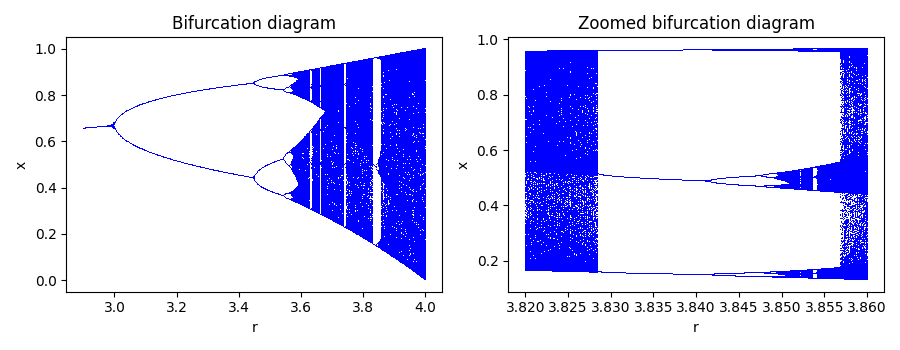

In [439]:
"""Bifurcation diagram"""


def calc_bifurcation(r_min, r_max, len_r=500, len_x=900):
    it_r = np.linspace(r_min, r_max, len_r)
    x_vals = np.zeros((len_r, len_x))
    y_vals = np.zeros((len_r, len_x))
    for n, r_ in enumerate(it_r):
        y, = time_series([0.1], eq, len_x + 200, r_)
        x_vals[n] = np.full(len_x, r_)
        y_vals[n] = y[200:]
    return x_vals.flatten(), y_vals.flatten()
    

def plot_bifurcation(ax, r_min, r_max, title):
    x, y = calc_bifurcation(r_min, r_max)
    ax.plot(x, y, c='blue', linestyle='None', marker=',')
    ax.set_xlabel('r')
    ax.set_ylabel('x')
    ax.set_title(title)

    
f7, axes7 = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5))
plot_bifurcation(axes7[0], 2.9, 4, 'Bifurcation diagram')
plot_bifurcation(axes7[1], 3.82, 3.86, 'Zoomed bifurcation diagram')
f7.tight_layout()
plt.show()

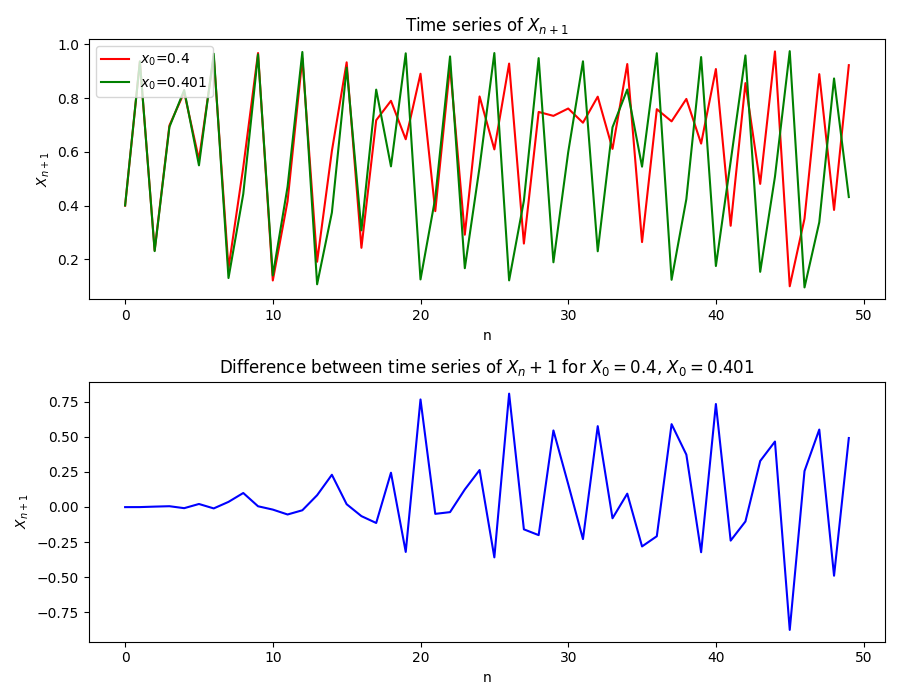

In [437]:
"""Hallmarks of chaos"""
def plot_time_series_diff(ax1, ax2, start, l, r):
    _, x1 = plot_time_series(ax1, [start[0]], 50, 3.9, c='red', style='-', marker=None)
    _, x2 = plot_time_series(ax1, [start[1]], 50, 3.9, c='green', style='-', marker=None)
    ax1.legend(loc='upper left')
    t = np.array(range(l))
    
    time, = ax2.plot(t, x1 - x2, c='blue')
    ax2.set_ylabel(r'$X_{n+1}$')
    ax2.set_xlabel('n')
    ax2.set_title(r'Difference between time series of $X_{}$ for $X_0 = {}$, $X_0 = {}$'.format('n+1', *start))


f8, axes8 = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_time_series_diff(*axes8, [0.4, 0.401], 50, 3.9)
f8.tight_layout()